# Assignment 1: Propagation and pass prediction 
This Jupyter Notebook is used in the Satellite Orbits Determination practical (AE4???). This notebook consists of 3 parts:
    - Propagation from a TLE 
    - Pass prediction over Delft ground station
    - Analysis of range-rate data from recording


### UNITS and conventions
All parameters are represented in SI units.

### Code usage
In this course you are using actual tracking data from the DopTrack laboratory and use the Delft-based orbit determination software Tudat to perform orbit analysis.

In [1]:
# Load standard modules
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression # linear regression module

from propagation_functions.environment import *
from propagation_functions.propagation import *
from utility_functions.time import *
from utility_functions.tle import *
from estimation_functions.observations_data import *
from estimation_functions.estimation import *

# Load tudatpy modules
from tudatpy.kernel import constants
from tudatpy.kernel.interface import spice
from tudatpy.kernel.numerical_simulation import propagation_setup
from tudatpy.kernel.astro import element_conversion

In [2]:
# Define import folders
metadata_folder = 'metadata/'
data_folder = 'data/'

# Metadata input file
metadata_file = metadata_folder + 'Delfi-C3_32789_202004020904.yml'

# Retrieve initial state from TLE and associated time
initial_epoch, initial_state_teme = get_tle_initial_conditions(metadata_file)

# Define start of the day (initial time of the propagation)
start_recording_day = get_start_next_day(initial_epoch)

# Define end of the day (final time of the propagation)
nb_days_to_propagate = 1.0
final_epoch = start_recording_day + nb_days_to_propagate * 86400.0 

print('initial epoch: ', initial_epoch)
print('initial state TEME: ', initial_state_teme)
print('final epoch', final_epoch)

initial epoch:  638983817.0000017
initial state TEME:  [-5.12028710e+06  4.67186002e+06 -1.02444750e+03  6.61803701e+02
  7.22033885e+02  7.51805584e+03]
final epoch 639144000.0


In [3]:
# --------------------------------------
# 1/ Propagate dynamics of Delfi
# --------------------------------------

===============  STARTING SINGLE-ARC PROPAGATION  ===============

PROCESSED STATE VECTOR CONTENTS: 
[Vector entries], content description
[0:5], Translational state of body Delfi w.r.t. Earth

DEPENDENT VARIABLE VECTOR CONTENTS: 
[Vector entries], content description
[0:5], Kepler elements of Delfi w.r.t. Earth
[6], Spherical position angle latitude angle of Delfi w.r.t. Earth
[7], Spherical position angle longitude angle of Delfi w.r.t. Earth




Warning when processing deprecated propagator settitngs, integrator settings defined independently, and in propagator settings


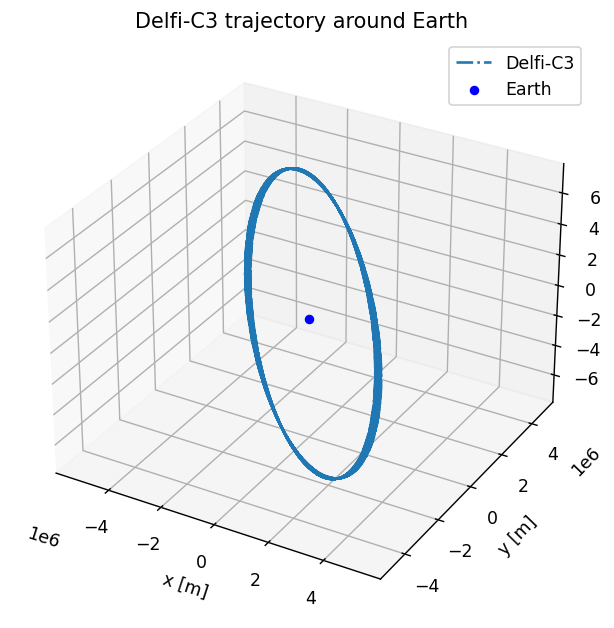

In [4]:
# Define the propagation environment. This function creates a body "Delfi" with the following characteristics.
# The Earth, Sun and Moon are also created, with default settings (gravity field, ephemeris, rotation, etc.)
mass_delfi = 2.2
reference_area_delfi = 0.035
drag_coefficient_delfi = 1.4
srp_coefficient_delfi = 2.4
bodies = define_environment(mass_delfi, reference_area_delfi, drag_coefficient_delfi, srp_coefficient_delfi)

# Set Delfi's initial state to the TLE prediction
initial_state = element_conversion.teme_state_to_j2000(initial_epoch, initial_state_teme)

# # Create numerical integrator settings
# integrator_settings = propagation_setup.integrator.runge_kutta_4(initial_epoch, 10.0)

# Define accelerations exerted on Delfi
# The following can be modified. Warning: point_mass_gravity and spherical_harmonic_gravity accelerations should not be defined simultaneously for a single body
acceleration_models = dict(
    Sun={
        'point_mass_gravity': True,
        'solar_radiation_pressure': True
    },
    Moon={
        'point_mass_gravity': True
    },
    Earth={
        'point_mass_gravity': False,
        'spherical_harmonic_gravity': True,
        'drag': True
    },
    Jupiter={
        'point_mass_gravity': True
    },
    Mars={
        'point_mass_gravity': True
    },
    Venus={
        'point_mass_gravity': True
    }
)
accelerations = create_accelerations(acceleration_models, bodies)

# Create propagator settings
propagator_settings = create_propagator_settings(initial_state, initial_epoch, final_epoch, accelerations)

# Propagate dynamics of the Delfi satellite from initial_epoch to final_epoch, starting from initial_state
# The propagation output is given in cartesian and keplerian states, and the latitude/longitude of the spacecraft are also saved.
cartesian_states, keplerian_states, latitudes, longitudes =\
    propagate_initial_state(initial_state, initial_epoch, final_epoch, bodies, accelerations)

# Plot propagated orbit
fig = plt.figure(figsize=(6,6), dpi=125)
ax = fig.add_subplot(111, projection='3d')
ax.set_title(f'Delfi-C3 trajectory around Earth')
ax.plot(cartesian_states[:, 1], cartesian_states[:, 2], cartesian_states[:, 3], label='Delfi-C3', linestyle='-.')
ax.scatter(0.0, 0.0, 0.0, label="Earth", marker='o', color='blue')
ax.legend()
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
plt.show()

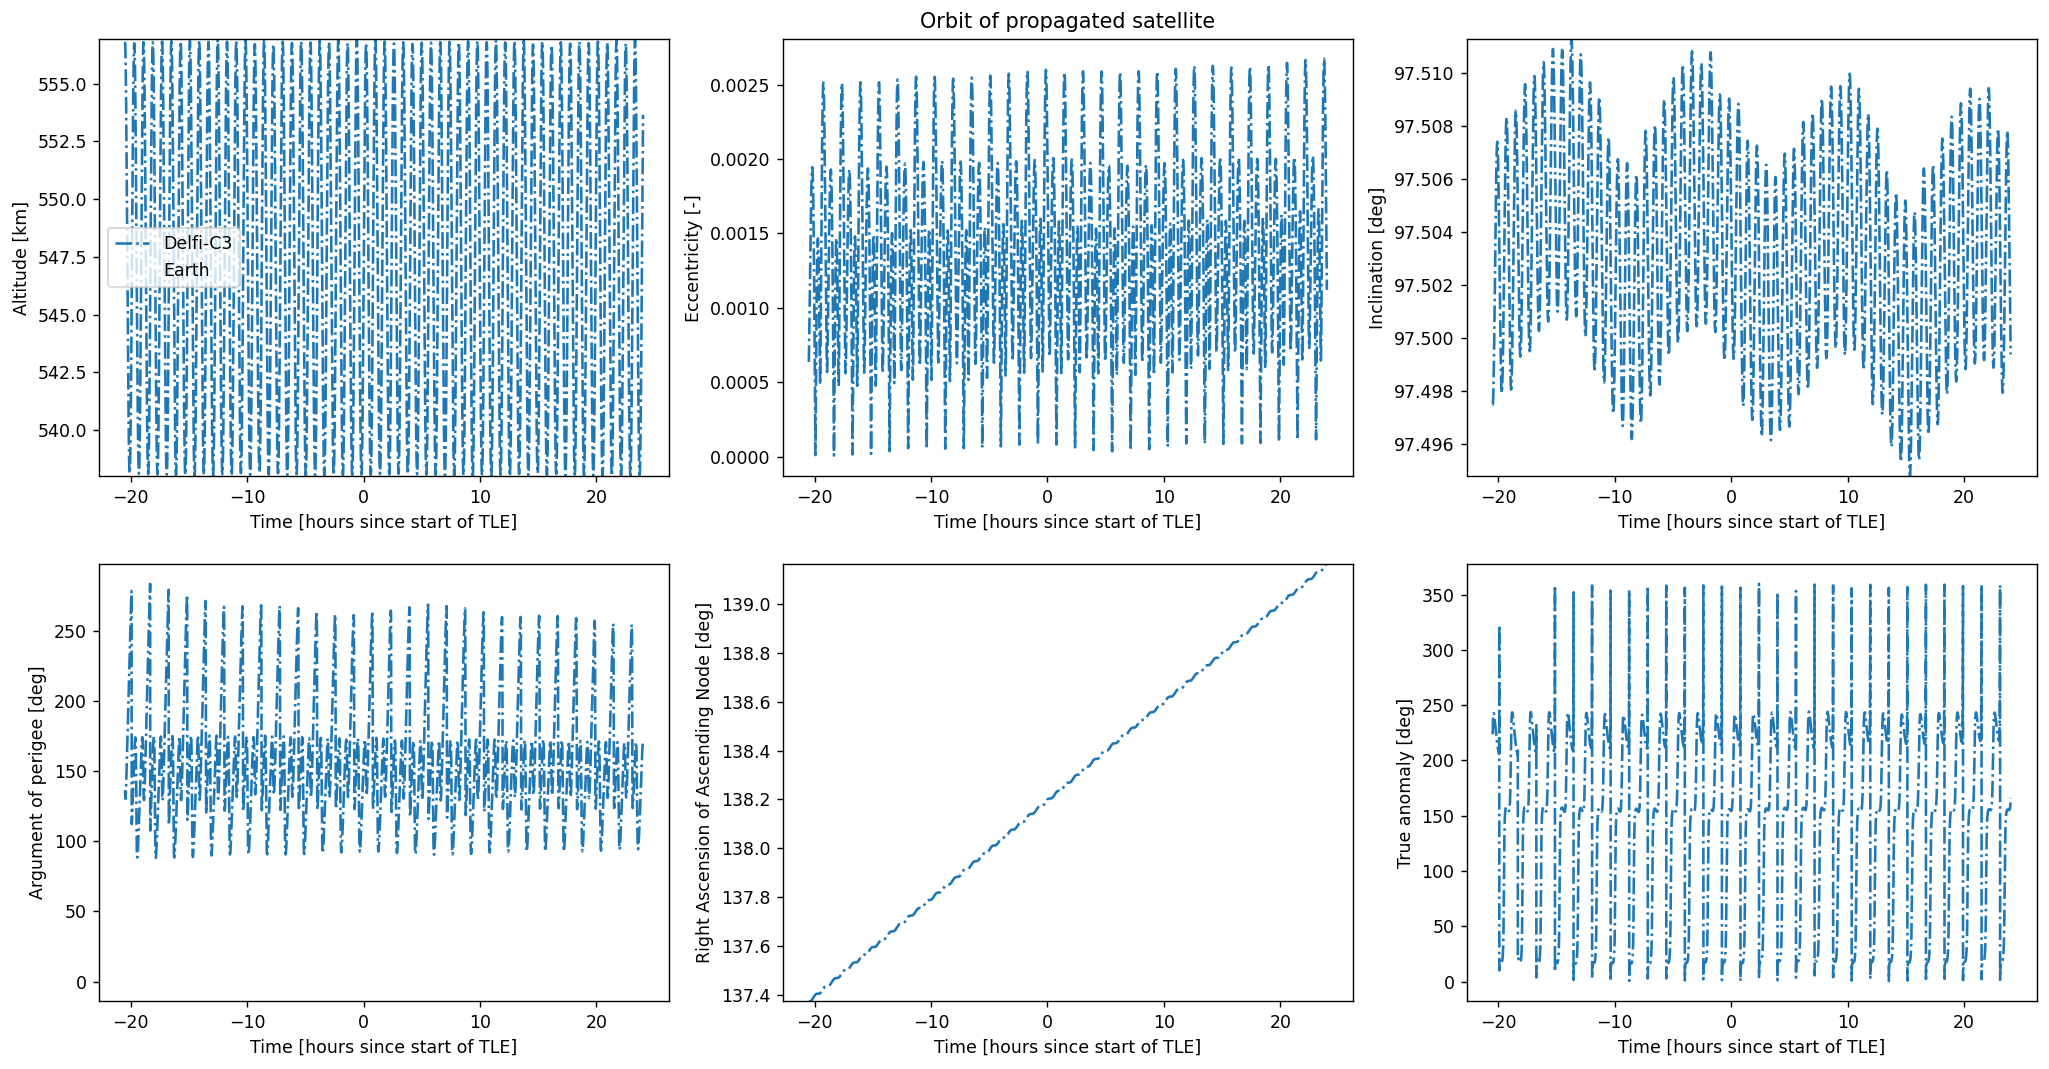

In [5]:
# Plot Keplerian coordinates and altitude of the propagated orbit
fig = plt.figure(figsize=(20,10), dpi=125)
ax = fig.add_subplot(231)
#ax.set_title(f'Altitude of delfi-C3')
ax.plot((keplerian_states[:, 0] - start_recording_day)/3600, (keplerian_states[:,1]-6371360)/1000, label='Delfi-C3', linestyle='-.')
ax.scatter(0.0, 0.0, 0.0, label="Earth", marker='o', color='blue')
ax.legend()
ax.set_ylim(np.min((keplerian_states[:,1]-6371360)/1000),np.max((keplerian_states[:,1]-6371360)/1000))
ax.set_xlabel('Time [hours since start of TLE]')
ax.set_ylabel('Altitude [km]')
#plt.show()

# eccentricity
ax = fig.add_subplot(232)
ax.set_title(f'Orbit of propagated satellite')
ax.plot((keplerian_states[:, 0] - start_recording_day)/3600, keplerian_states[:,2], label='Delfi-C3', linestyle='-.')
ax.scatter(0.0, 0.0, 0.0, label="Earth", marker='o', color='blue')
#ax.legend()
ax.set_xlabel('Time [hours since start of TLE]')
ax.set_ylabel('Eccentricity [-]')
#plt.show()

# inclination
ax = fig.add_subplot(233)
#ax.set_title(f'Altitude of delfi-C3')
ax.plot((keplerian_states[:, 0] - start_recording_day)/3600, keplerian_states[:,3]/np.pi*180, label='Delfi-C3', linestyle='-.')
ax.scatter(0.0, 0.0, 0.0, label="Earth", marker='o', color='blue')
#ax.legen
ax.set_ylim(np.min((keplerian_states[:,3])/np.pi*180),np.max((keplerian_states[:,3])/np.pi*180))
ax.set_xlabel('Time [hours since start of TLE]')
ax.set_ylabel('Inclination [deg]')
#plt.show()

ax = fig.add_subplot(234)
#ax.set_title(f'Altitude of delfi-C3')
ax.plot((keplerian_states[:, 0] - start_recording_day)/3600, (keplerian_states[:,4])/np.pi*180, label='Delfi-C3', linestyle='-.')
ax.scatter(0.0, 0.0, 0.0, label="Earth", marker='o', color='blue')
#ax.legend()
ax.set_xlabel('Time [hours since start of TLE]')
ax.set_ylabel('Argument of perigee [deg]')
#plt.show()

# eccentricity
ax = fig.add_subplot(235)
#ax.set_title(f'Altitude of delfi-C3')
ax.plot((keplerian_states[:, 0] - start_recording_day)/3600, keplerian_states[:,5]/np.pi*180, label='Delfi-C3', linestyle='-.')
ax.scatter(0.0,0.0, 0.0, label="Earth", marker='o', color='blue')
#ax.legend()
ax.set_ylim(np.min((keplerian_states[:,5])/np.pi*180),np.max((keplerian_states[:,5])/np.pi*180))
ax.set_xlabel('Time [hours since start of TLE]')
ax.set_ylabel('Right Ascension of Ascending Node [deg]')
#plt.show()

# inclination
ax = fig.add_subplot(236)
#ax.set_title(f'Altitude of delfi-C3')
ax.plot((keplerian_states[:, 0] - start_recording_day)/3600, keplerian_states[:,6]/np.pi*180, label='Delfi-C3', linestyle='-.')
ax.scatter(0.0, 0.0, 0.0, label="Earth", marker='o', color='blue')
#ax.legend()
ax.set_xlabel('Time [hours since start of TLE]')
ax.set_ylabel('True anomaly [deg]')
plt.show()


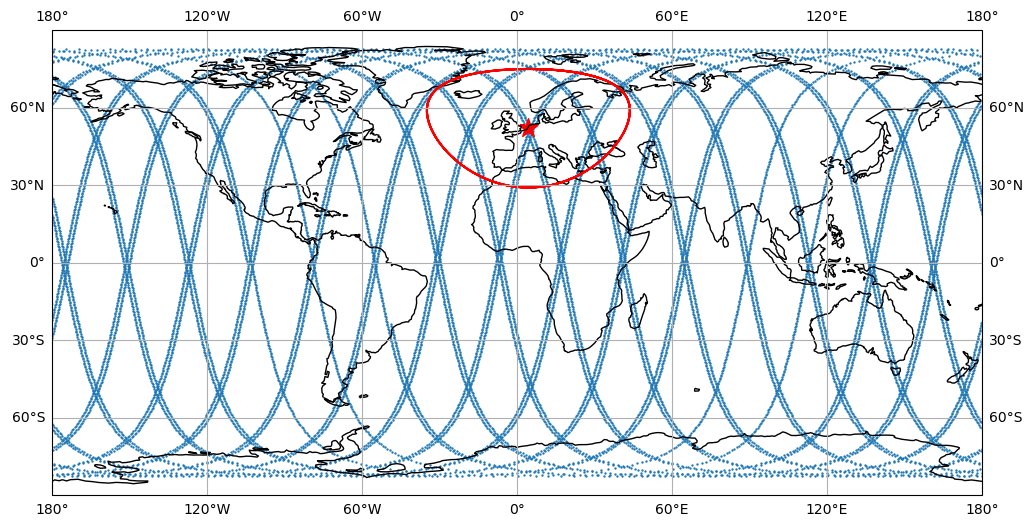

In [6]:
# plot the ground track and visibility circle of the DopTrack station

location_groundstation_lon = 4.3754
location_groundstation_lat = 51.9899

R = 6371360 
h =  547500;
Lambda = np.arccos((R)/(R+h))
Phi_E = np.linspace(0, 2*np.pi, num=1000)

# Create hemisphere function
mask_E = []
for i in range(len(Phi_E)):
    val = (-Phi_E[i]) % 2*np.pi
    if val >= 0 and val < np.pi: 
        mask_E.append(1.0)
    else:
        mask_E.append(-1.0)
     
    
# Calculate horizon coordinates on the map. 
colat_horizon = np.arccos(np.cos(Lambda)*np.cos((90-location_groundstation_lat)/180*np.pi)+np.sin(Lambda)*np.sin((90-location_groundstation_lat)/180*np.pi)*np.cos(Phi_E % 2*np.pi)) 
DL = ((mask_E * np.arccos((np.cos(Lambda)-np.cos(colat_horizon)*np.cos((90-location_groundstation_lat)/180*np.pi))/(np.sin((90-location_groundstation_lat)/180*np.pi)*np.sin(colat_horizon)))))
                        
LAT_horizon = (90-(colat_horizon/np.pi*180))
LON_horizon_abs = ((location_groundstation_lon/180*np.pi-DL)/np.pi*180) 
LON_horizon = np.where(LON_horizon_abs <= 180, LON_horizon_abs, LON_horizon_abs - 360)
             
# plot groundtrack with visibility area of ground station
plt.figure(figsize = (12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.scatter(longitudes/np.pi*180, latitudes/np.pi*180, label='Delfi-C3', marker='.',s=2)
ax.scatter(location_groundstation_lon,location_groundstation_lat, color='red', marker='*',s=200)
ax.plot(LON_horizon,LAT_horizon,color ='red')
ax.gridlines(draw_labels=True)
plt.show()

# --------------------------------------
# 2/ Detect passes and simulate Doppler
# --------------------------------------

Now that you are able to propagate orbits from a TLE data source and plot the ground track on the surface of the Earth, it is time to determine when a satellite is passing over the ground station (in Delft). This you will need to plan access to the DopTrack laboratory.

In previeous code you can set the time of propagation to any numbers. From literature it is found that TLE data is accurate up to 10 days for this application, having the most accurate orbit predictions close to the TLE time.

Lecture on visibility plots and constrcuting range-rate

Parameter start index, Parameter definition
0, translational state of (Delfi).

===============  STARTING SINGLE-ARC PROPAGATION  ===============

PROCESSED STATE VECTOR CONTENTS: 
[Vector entries], content description
[0:5], Translational state of body Delfi w.r.t. Earth

DEPENDENT VARIABLE VECTOR CONTENTS: 
[Vector entries], content description
[0:5], Kepler elements of Delfi w.r.t. Earth
[6], Spherical position angle latitude angle of Delfi w.r.t. Earth
[7], Spherical position angle longitude angle of Delfi w.r.t. Earth




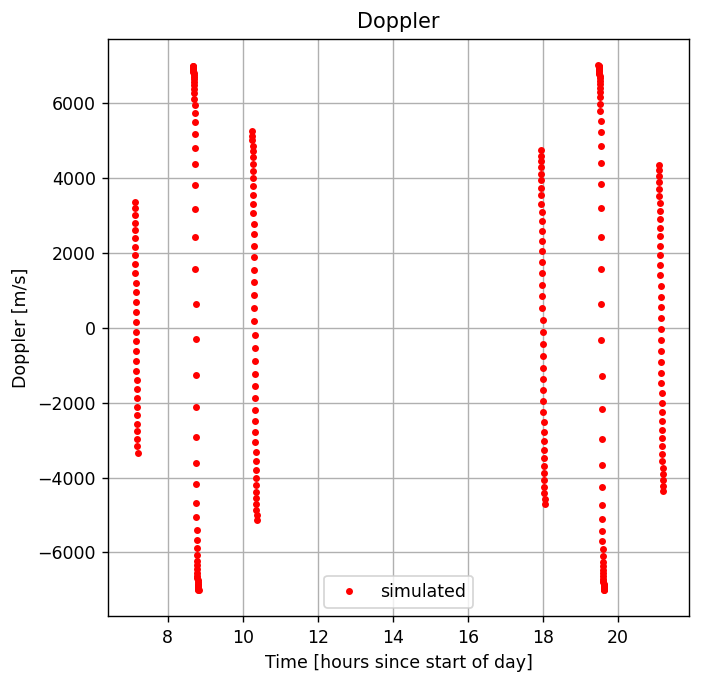

In [7]:
# Create the DopTrack station
define_doptrack_station(bodies)

# Define observation settings
observation_settings = define_ideal_doppler_settings()

# Create list of observation times, with one Doppler measurement every 10 seconds
possible_obs_times = []
obs_time_step = 10.0
current_time = start_recording_day
while current_time < final_epoch:
    possible_obs_times.append(current_time)
    current_time = current_time + obs_time_step

# Simulate (ideal) observations
# Checking the vivibility in the obseration window and calculataing ideal range rate.
simulated_observations = simulate_observations(possible_obs_times, observation_settings, propagator_settings, bodies, initial_epoch, 5)

simulated_obs_times = np.array(simulated_observations.concatenated_times)
simulated_doppler = simulated_observations.concatenated_observations

# Plot simulated Doppler data
fig = plt.figure(figsize=(6,6), dpi=125)
ax = fig.add_subplot()
ax.set_title(f'Doppler')
ax.plot((simulated_obs_times - start_recording_day)/3600, simulated_doppler, label='simulated', color='red', linestyle='none', marker='.')
ax.legend()
ax.set_xlabel('Time [hours since start of day]')
ax.set_ylabel('Doppler [m/s]')
plt.grid()
plt.show()

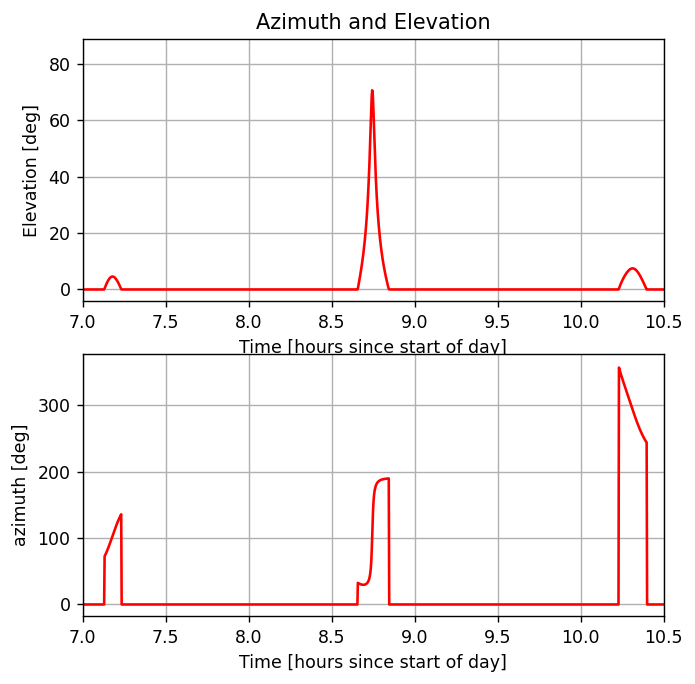

In [8]:
# plot elevation and azimuth of the passes (max and horizon)
sin_rho = R/(R+h)
DL_e = np.deg2rad(np.rad2deg(longitudes[:,1])-location_groundstation_lon)
Lambda_e = np.arccos(np.cos(latitudes[:,1])*np.cos(np.deg2rad(location_groundstation_lat))+np.sin(latitudes[:,1])*np.sin(np.deg2rad(location_groundstation_lat))*np.cos(DL_e))

eta = np.arctan2(sin_rho*np.sin(Lambda_e),1-sin_rho*np.cos(Lambda_e))
elevation_abs = np.rad2deg(np.arccos(np.sin(eta)/sin_rho))
elevation_lambda_check = np.where(Lambda_e <= np.arccos(R/(R+h)), elevation_abs, 0)
elevation = np.where(np.abs(DL_e)<= 0.5*np.pi, elevation_lambda_check, 0)

# Plot elevation
fig = plt.figure(figsize=(6,6), dpi=125)
ax = fig.add_subplot(211)
ax.set_title(f'Azimuth and Elevation')
ax.plot((longitudes[:,0] - start_recording_day)/3600, elevation, color='red')
#ax.set_xlim((simulated_obs_times[1] - start_recording_day)/3600,(simulated_obs_times[-1] - start_recording_day)/3600)
ax.set_xlim(7.0, 10.5)
ax.set_xlabel('Time [hours since start of day]')
ax.set_ylabel('Elevation [deg]')
plt.grid()
#plt.show()

# Azimuth calculation

# Create hemisphere function
mask_DL = []
for i in range(len(DL_e)):
    val = (DL_e[i]) % 2*np.pi
    if val >= 0 and val < np.pi: 
        mask_DL.append(1.0)
    else:
        mask_DL.append(-1.0)
        
# azimuth

azimuth_abs = np.rad2deg(mask_DL*np.arccos((np.cos(np.deg2rad(location_groundstation_lat))-np.cos(latitudes[:,1])*np.cos(Lambda_e))/(np.sin(latitudes[:,1])*np.sin(Lambda_e))))
azimuth_lambda_check = np.where(Lambda_e <= np.arccos(R/(R+h)), azimuth_abs, 0)
azimuth = np.where(np.abs(DL_e)<= 0.5*np.pi, azimuth_lambda_check, 0)

ax = fig.add_subplot(212)
ax.plot((longitudes[:,0] - start_recording_day)/3600, azimuth % 360, color='red')
#ax.set_xlim((simulated_obs_times[1] - start_recording_day)/3600,(simulated_obs_times[-1] - start_recording_day)/3600)
ax.set_xlim(7.0, 10.5)
ax.set_xlabel('Time [hours since start of day]')
ax.set_ylabel('azimuth [deg]')
plt.grid()
plt.show()

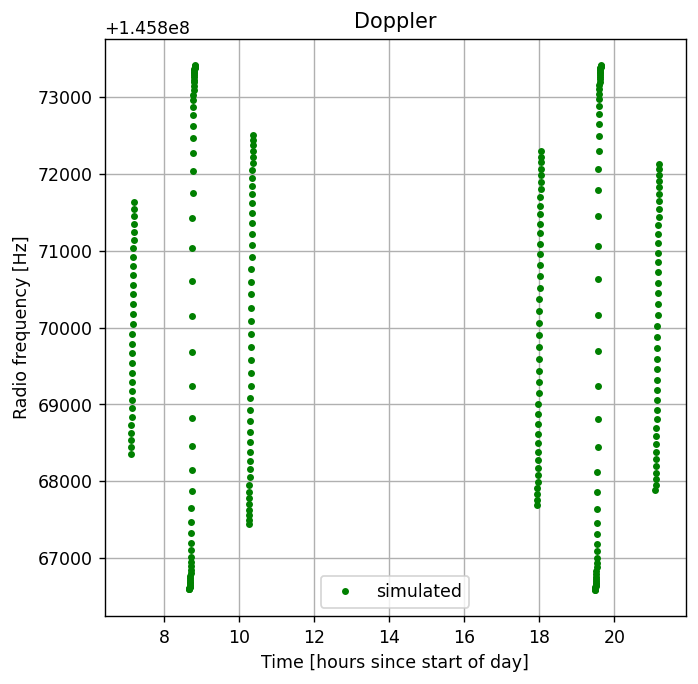

In [13]:
# with doppler formula, calculate simulated frequency
satellite_frequency = 145870000
speed_of_light = 299792458

frequency_received = (1-simulated_doppler/speed_of_light)*satellite_frequency

# Plot simulated freuqency data
fig = plt.figure(figsize=(6,6), dpi=125)
ax = fig.add_subplot()
ax.set_title(f'Doppler')
ax.plot((simulated_obs_times - start_recording_day)/3600, frequency_received, label='simulated', color='green', linestyle='none', marker='.')
ax.legend()
ax.set_xlabel('Time [hours since start of day]')
ax.set_ylabel('Radio frequency [Hz]')
plt.grid()
plt.show()

# --------------------------------------
# 3/ Load real observations
# --------------------------------------

During your visit at the DopTrack facility, you have recorded your own frequency passes and the automated processor has converted the frequeency measurements into range-rate data. 

LECTURE on how this is done.

Now it is your time to look at the data recorded and how well they are related to the simulated observations.

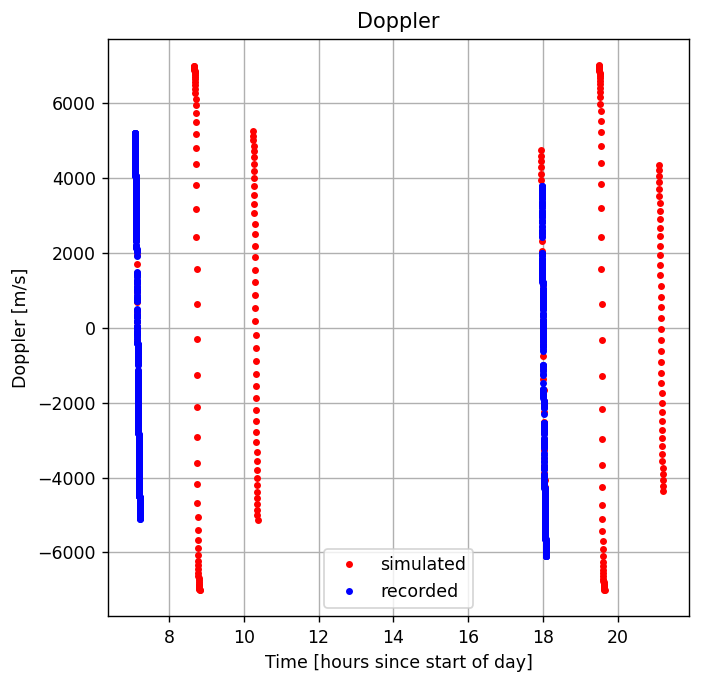

In [38]:
# Observation files to be uploaded
data = ['Delfi-C3_32789_202004020904.DOP1C', 'Delfi-C3_32789_202004021953.DOP1C', 'Delfi-C3_32789_202004022126.DOP1C']

# Process observations.
# This loads the recorded observations and retrieve the start of each tracking pass
passes_start_times, passes_end_times, observation_times, observations_set = load_and_format_observations(data_folder, data, [])

# Retrieve measured Doppler values
real_doppler = observations_set.concatenated_observations


# Plot simulated vs. real Doppler
fig = plt.figure(figsize=(6,6), dpi=125)
ax = fig.add_subplot()
ax.set_title(f'Doppler')
ax.plot((np.array(simulated_obs_times) - start_recording_day)/3600, simulated_doppler, label='simulated', color='red', linestyle='none', marker='.')
ax.plot((np.array(observation_times) - start_recording_day)/3600, convert_frequencies_to_range_rate(real_doppler), label='recorded', color='blue', linestyle='none', marker='.')
ax.legend()
ax.set_xlabel('Time [hours since start of day]')
ax.set_ylabel('Doppler [m/s]')
plt.grid()
plt.show()

In [22]:
# --------------------------------------
# 4/ Compare simulated and recorded data for single pass
# --------------------------------------

In [39]:
# Index of the *recorded* pass of interest (warning: the number of recorded passes might differ from the number of simulated passes)
index_pass = 2
single_pass_start_time = passes_start_times[index_pass]
single_pass_end_time = passes_end_times[index_pass]

# Retrieve recorded Doppler data for single pass
real_obs_single_pass = get_observations_single_pass(single_pass_start_time, single_pass_end_time, observations_set)

# Retrieve simulated Doppler data for single pass
simulated_obs_single_pass = get_observations_single_pass(single_pass_start_time, single_pass_end_time, simulated_observations)

# Interpolate simulated and recorded observations to identical times
interpolated_simulated_obs, interpolated_real_obs = interpolate_obs(simulated_obs_single_pass, real_obs_single_pass)
interpolated_times = interpolated_simulated_obs[:,0]

# Compute first residual between recorded and simulated observations
first_residual_obs = interpolated_real_obs[:,1] - interpolated_simulated_obs[:,1]


# Plot single pass observations (both recorded and simulated, as well as first and second residuals)

fig = plt.figure(figsize=(10,6), dpi=125)
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)

ax1 = fig.add_subplot(2,2,1)
ax3 = fig.add_subplot(2,2,2)

ax1.plot((interpolated_times - start_recording_day)/3600, interpolated_real_obs[:,1], label='recorded', color='blue', linestyle='none', marker='.')
ax1.plot((interpolated_times - start_recording_day)/3600, interpolated_simulated_obs[:,1], label='simulated', color='red', linestyle='none', marker='.')
ax1.grid()
ax1.set_title(f'Doppler')
ax1.legend()
ax1.set_xlabel('Time [hours since start of day]')
ax1.set_ylabel('Doppler [m/s]')

ax3.plot((interpolated_times - start_recording_day)/3600, first_residual_obs, label='first residual', color='green', linestyle='none', marker='.')
ax3.grid()
ax3.set_title(f'First residual (recorded - simulated)')
ax3.legend()
ax3.set_xlabel('Time [hours since start of day]')
ax3.set_ylabel('Residual [m/s]')

plt.show()

IndexError: list index out of range

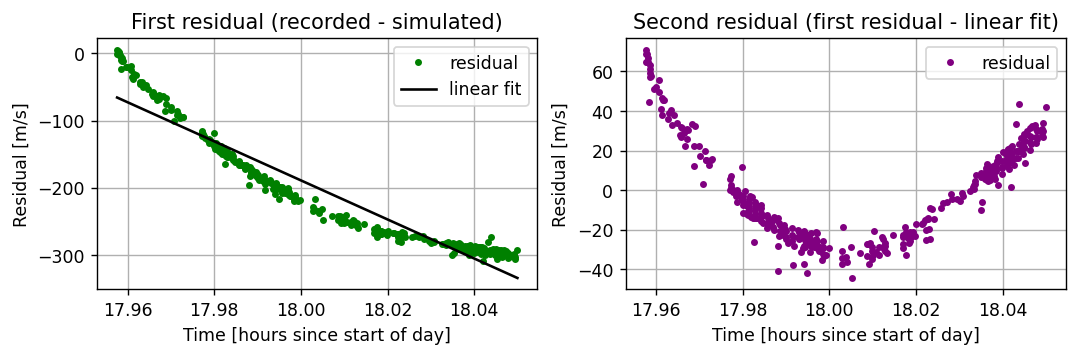

In [35]:
# Perform linear regression on first residual
linear_fit = LinearRegression().fit(interpolated_times.reshape((-1, 1)), first_residual_obs)

# Retrieve fit model
fit = linear_fit.predict(np.linspace(interpolated_times[0], interpolated_times[len(interpolated_times)-1]).reshape((-1, 1)))

# Compute second residual after removing linear fit
second_residual_obs = first_residual_obs - linear_fit.predict(interpolated_times.reshape((-1, 1)))

fig = plt.figure(figsize=(10,6), dpi=125)
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)

ax3 = fig.add_subplot(2,2,1)
ax4 = fig.add_subplot(2,2,2)

ax3.plot((interpolated_times - start_recording_day)/3600, first_residual_obs, label='residual', color='green', linestyle='none', marker='.')
ax3.plot((np.linspace(interpolated_times[0], interpolated_times[len(interpolated_times)-1]) - start_recording_day)/3600, fit, label='linear fit', color='black', linestyle='-')
ax3.grid()
ax3.set_title(f'First residual (recorded - simulated)')
ax3.legend()
ax3.set_xlabel('Time [hours since start of day]')
ax3.set_ylabel('Residual [m/s]')

ax4.plot((interpolated_times - start_recording_day)/3600, second_residual_obs, label='residual', color='purple', linestyle='none', marker='.')
ax4.grid()
ax4.set_title(f'Second residual (first residual - linear fit)')
ax4.legend()
ax4.set_xlabel('Time [hours since start of day]')
ax4.set_ylabel('Residual [m/s]')

plt.show()